In [1]:
# To support both python 2 and python 3
# 让这份笔记同步支持 python 2 和 python 3
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

**11. On the book website, www.StatLearning.com, there is a gene expression data set ( Ch10Ex11.csv ) that consists of 40 tissue samples with
measurements on 1,000 genes. The first 20 samples are from healthy
patients, while the second 20 are from a diseased group.
418 10. Unsupervised Learning
(a) Load in the data using read.csv() . You will need to select
header=F.**

In [2]:
gene_data = pd.read_csv('Data/Ch10Ex11.csv', na_values='?', header= None).dropna() 

**(b) Apply hierarchical clustering to the samples using correlation-
based distance, and plot the dendrogram. Do the genes separate
the samples into the two groups? Do your results depend on the
type of linkage used?**

In [3]:
'''参考10.7 
if each observation has been centered to have mean zero and standard deviation one, and if we let r ij denote the correlation between the ith
and jth observations, then the quantity 1−r ij is proportional to the squared Euclidean distance between the ith and jth observations.
'''
from sklearn.preprocessing import scale
X = scale(gene_data).T

In [4]:
from scipy.cluster import hierarchy
hc_complete = hierarchy.complete(X)
hc_average = hierarchy.average(X)
hc_single = hierarchy.single(X)

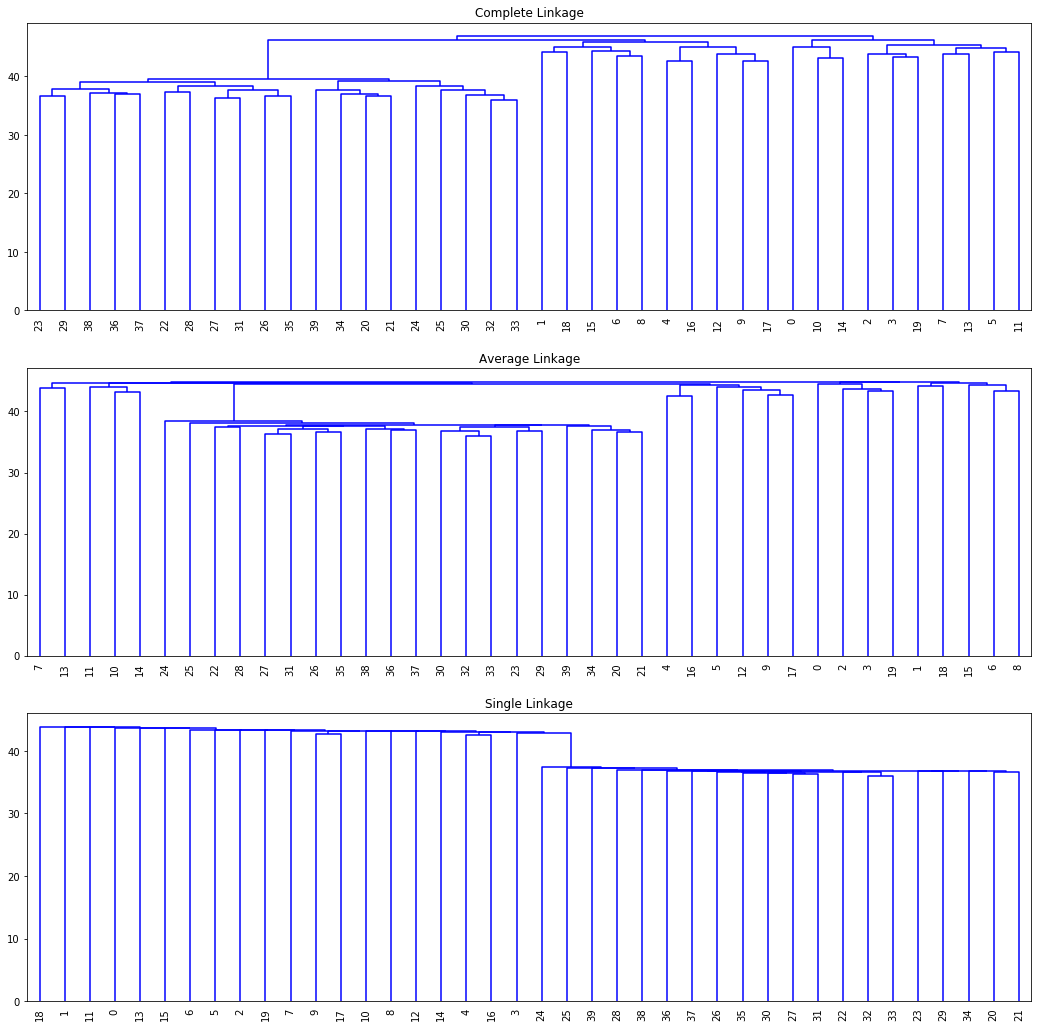

In [5]:
#参考https://github.com/JWarmenhoven/ISLR-python
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(18,18))

for linkage, cluster, ax in zip([hierarchy.complete(X), hierarchy.average(X), hierarchy.single(X)], ['c1','c2','c3'],
                                [ax1,ax2,ax3]):
    cluster = hierarchy.dendrogram(linkage, ax=ax, color_threshold=0,leaf_rotation=90.,leaf_font_size=10.)

ax1.set_title('Complete Linkage')
ax2.set_title('Average Linkage')
ax3.set_title('Single Linkage');

In [6]:
hierarchy.cut_tree(hc_complete , 2).T

array([[0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [7]:
hierarchy.cut_tree(hc_average , 2).T

array([[0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [8]:
hierarchy.cut_tree(hc_single , 2).T

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

从结果上看与距离类型强相关

**(c) Your collaborator wants to know which genes differ the most
across the two groups. Suggest a way to answer this question,
and apply it here.**

In [9]:
#初步怀疑在对样本标准化后的数据中（根据10.7与相关性成正比），方差越大影响越大，但是后面换了一种方法并不一样
test = pd.DataFrame(X.var(axis = 0))
test.sort_values(by = 0,ascending=False).head()

,0
528,2.174998
581,2.141515
567,2.116592
548,2.061165
539,1.970682


In [10]:
#考虑方法2，对基因逐个抽去，影响分类结果最大的应该就是区分作用最大基因
def compare_hierarchy_cut(cut_num,i):
    hierarchy_cut_orgin = hierarchy.cut_tree(hc_complete , cut_num)
    X_compare = scale(gene_data.drop(i)).T
    hc_complete_compare = hierarchy.complete(X_compare)
    hierarchy_cut_compare = hierarchy.cut_tree(hc_complete_compare , cut_num)
    return(hierarchy_cut_compare!= hierarchy_cut_orgin).sum()
    #return min((hierarchy_cut_compare!= hierarchy_cut_orgin).sum(),(hierarchy_cut_compare == hierarchy_cut_orgin).sum())

In [11]:
test_2 = pd.DataFrame(columns = ['Variation'])
for i in range(len(gene_data)):
    test_2.loc[i] = compare_hierarchy_cut(2,i)
test_2.sort_values(by = 'Variation',ascending=False).head()

,Variation
931,9
469,9
910,9
810,9
822,9


这里931、469、...等对2分类影响大，但引起同样变化(9个样本重新分类)的基因比较多，需要进一步分类比较。

In [12]:
test_2['Variation_4'] = np.empty(1000)
Variation_value = []
for i in range(len(gene_data)):
    Variation_value.append(compare_hierarchy_cut(4,i))
test_2['Variation_4'] = Variation_value
test_2.sort_values(by = 'Variation_4',ascending=False).head()

,Variation,Variation_4
931,9,13
945,9,13
910,9,13
810,9,13
822,9,13


这里931、945、...等对4分类影响大，但引起同样变化(13个样本重新分类)的基因比较多，需要进一步分类比较。

In [13]:
test_2['Variation_16'] = np.empty(1000)
Variation_value = []
for i in range(len(gene_data)):
    Variation_value.append(compare_hierarchy_cut(16,i))
test_2['Variation_16'] = Variation_value
test_2.sort_values(by = 'Variation_16',ascending=False).head()

,Variation,Variation_4,Variation_16
987,9,13,17
200,9,13,17
0,0,0,0
667,0,0,0
671,9,13,0


这里200和987对2/4/16分类影响大，可以判定为对区分两个类的作用最大。

In [14]:
#考虑方法3，对源数据取PCA看哪个变量的负荷最大
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [15]:
total_load = pd.DataFrame(np.abs(pca.components_).sum(axis = 0))

In [16]:
total_load.sort_values(by = 0,ascending=False).head()

,0
913,1.342050
548,1.336994
152,1.334069
908,1.315850
528,1.313305
